In the [previous post](http://anotherdatum.com/vae.html) of this series I introduced the Variational Autoencoder (VAE) framework, and explained the theory behind it.

In this post I'll explain the VAE in more detail, or in other words - I'll provide some code :)

After reading this post, you'll understand the technical details needed to implement VAE.

As a bonus point, I'll show you how by imposing a special role to some of the latent vector's dimensions, the model can generate images conditioned on the digit type.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

np.random.seed(42)
tf.set_random_seed(42)

%matplotlib inline

The model will be trained on [MNIST](https://en.wikipedia.org/wiki/MNIST_database) - handwritten digits dataset. The input is an image in $\mathbb{R}^{28×28}$.

In [2]:
mnist = input_data.read_data_sets('MNIST_data')
input_size = 28 * 28
num_digits = 10

Next we'll define the hyperparameters we're going to use.

Feel free to play with different values to get a feeling of how the model is affected. The notebook can be found [here](https://github.com/yoel-zeldes/yoel-zeldes.github.io/blob/source/content/vae2/vae2.ipynb).

In [3]:
params = {
    'encoder_layers': [128],                # the encoder will be implemented using a simple feed forward network
    'decoder_layers': [128],                # and so will the decoder (CNN will be better, but I want to keep the code simple)
    'digit_classification_layers': [128],   # this is for the conditioning. I'll explain it later on
    'activation': tf.nn.sigmoid,            # the activation function used by all sub-networks
    'decoder_std': 0.5,                     # the standard deviation of P(x|z) discussed in the previous post
    'z_dim': 10,                            # the dimension of the latent space
    'digit_classification_weight': 10.0,    # this is for the conditioning. I'll explain it later on
    'epochs': 20,
    'batch_size': 100,
    'learning_rate': 0.001
}

# The Model
![](images/vae2/model.jpg)

The model is composed of three sub-networks:
1. Given $x$ (image), encode it into a distribution over the latent space - referred to as $Q(z|x)$ in the previous post.
2. Given $z$ in latent space (code representation of an image), decode it into the image it represents - referred to as $f(z)$ in the previous post.
3. Given $x$, classify its digit by mapping it to a layer of size 10 where the i'th value contains the probability of the i'th digit.

The first two sub-networks are the vanilla VAE framework.

The third one is used as an [auxiliary task](http://ruder.io/multi-task/index.html), which will enforce some of the latent dimensions to encode the digit found in an image. Let me explain the motivation: in the previous post I explained that we don't care what information each dimension of the latent space holds. The model can learn to encode whatever information it finds valuable for its task. Since we're familiar with the dataset, we know the digit type should be important. We want to help the model by providing it with this information. Moreover, we'll use this information to generate images conditioned on the digit type, as I'll explain later.

Given the digit type, we'll encode it using one hot encoding, that is, a vector of size 10. These 10 numbers will be concatenated into the latent vector, so when decoding that vector into an image, the model will make use of the digit information.

There are two ways to provide the model with a one hot encoding vector:
1. Add it as an input to the model.
2. Add it as a label so the model will have to predict it by itself: we'll add another sub-network that predicts a vector of size 10 where the loss is the cross entropy with the expected one hot vector.

We'll go with the second option. Why? Well, in test time we can use the model in two ways:
1. Provide an image as input, and infer a latent vector.
2. Provide a latent vector as input, and generate an image.

Since we want to support the first option too, we can't provide the model with the digit as input, since we won't know it in test time. Hence, the model must learn to predict it.

Now that we understand all the sub-networks composing the model, we can code them. The mathematical details behind the encoder and decoder can be found in the previous post.

In [4]:
def encoder(x, layers):
    for layer in layers:
        x = tf.layers.dense(x,
                            layer,
                            activation=params['activation'])
    mu = tf.layers.dense(x, params['z_dim'])
    var = 1e-5 + tf.exp(tf.layers.dense(x, params['z_dim']))
    return mu, var


def decoder(z, layers):
    for layer in layers:
        z = tf.layers.dense(z,
                            layer,
                            activation=params['activation'])
    mu = tf.layers.dense(z, input_size)
    return tf.nn.sigmoid(mu)


def digit_classifier(x, layers):
    for layer in layers:
        x = tf.layers.dense(x,
                            layer,
                            activation=params['activation'])
    logits = tf.layers.dense(x, num_digits)
    return logits

In [5]:
images = tf.placeholder(tf.float32, [None, input_size])
digits = tf.placeholder(tf.int32, [None])

# encode an image into a distribution over the latent space
encoder_mu, encoder_var = encoder(images,
                                  params['encoder_layers'])

# sample a latent vector from the latent space - using the reparameterization trick
eps = tf.random_normal(shape=[tf.shape(images)[0],
                              params['z_dim']],
                       mean=0.0,
                       stddev=1.0)
z = encoder_mu + tf.sqrt(encoder_var) * eps

# classify the digit
digit_logits = digit_classifier(images,
                                params['digit_classification_layers'])
digit_prob = tf.nn.softmax(digit_logits)

# decode the latent vector - concatenated to the digits classification - into an image
decoded_images = decoder(tf.concat([z, digit_prob], axis=1),
                         params['decoder_layers'])

In [6]:
# the loss is composed of how well we can reconstruct the image
loss_reconstruction = -tf.reduce_sum(
    tf.contrib.distributions.Normal(
        decoded_images,
        params['decoder_std']
    ).log_prob(images),
    axis=1
)

# and how off the distribution over the latent space is from the prior.
# Given the prior is a standard Gaussian and the inferred distribution
# is a Gaussian with a diagonal covariance matrix, the KL-divergence
# becomes analytically solvable, and we get
loss_prior = -0.5 * tf.reduce_sum(
    1 + tf.log(encoder_var) - encoder_mu ** 2 - encoder_var,
    axis=1
)

loss_auto_encode = tf.reduce_mean(
    loss_reconstruction + loss_prior,
    axis=0
)

# digit_classification_weight is used to weight between the two losses,
# since there's a tension between them
loss_digit_classifier = params['digit_classification_weight'] * tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=digits,
                                                   logits=digit_logits),
    axis=0
)

loss = loss_auto_encode + loss_digit_classifier

train_op = tf.train.AdamOptimizer(params['learning_rate']).minimize(loss)

# Training
![](images/vae2/training.jpg)

We'll train the model to optimize the two losses - the VAE loss and the classification loss - using [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).

At the end of every epoch we'll sample latent vectors and decode them into images, so we can visualize how the generative power of the model improves over the epochs. The sampling method is as follows:
1. Deterministically set the dimensions which are used for digit classification according to the digit we want to generate an image for. If for example we want to generate an image of the digit 2, these dimensions will be set to $[0010000000]$.
2. Randomly sample the other dimensions according to the prior - a multivariate Gaussian. We'll use these sampled values for all the different digits we generate in a given epoch. This way we can have a feeling of what is encoded in the other dimensions, for example stroke style.

The intuition behind step 1 is that after convergence the model should be able to classify the digit in an input image using these dimensions. On the other hand, these dimensions are also used in the decoding step to generate the image. It means the decoder sub-network learns that when these dimensions have the values corresponding to the digit 2, it should generate an image of that digit. Therefore, if we manually set these dimensions to contain the information of the digit 2, we'll get a generated image of that digit.

In [7]:
samples = []
losses_auto_encode = []
losses_digit_classifier = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in xrange(params['epochs']):
        for _ in xrange(mnist.train.num_examples / params['batch_size']):
            batch_images, batch_digits = mnist.train.next_batch(params['batch_size'])
            sess.run(train_op, feed_dict={images: batch_images, digits: batch_digits})
        
        train_loss_auto_encode, train_loss_digit_classifier = sess.run(
            [loss_auto_encode, loss_digit_classifier],
            {images: mnist.train.images, digits: mnist.train.labels})
        
        losses_auto_encode.append(train_loss_auto_encode)
        losses_digit_classifier.append(train_loss_digit_classifier)
        
        sample_z = np.tile(np.random.randn(1, params['z_dim']), reps=[num_digits, 1])
        gen_samples = sess.run(decoded_images,
                               feed_dict={z: sample_z, digit_prob: np.eye(num_digits)})
        samples.append(gen_samples)

Let's verify both losses look good, that is - decreasing:

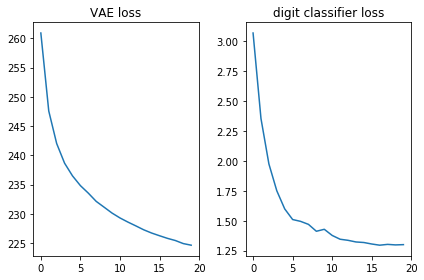

In [8]:
plt.subplot(121)
plt.plot(losses_auto_encode)
plt.title('VAE loss')

plt.subplot(122)
plt.plot(losses_digit_classifier)
plt.title('digit classifier loss')

plt.tight_layout()

Additionally, let's plot the generated images to see if indeed the model was able to generate images of digits:

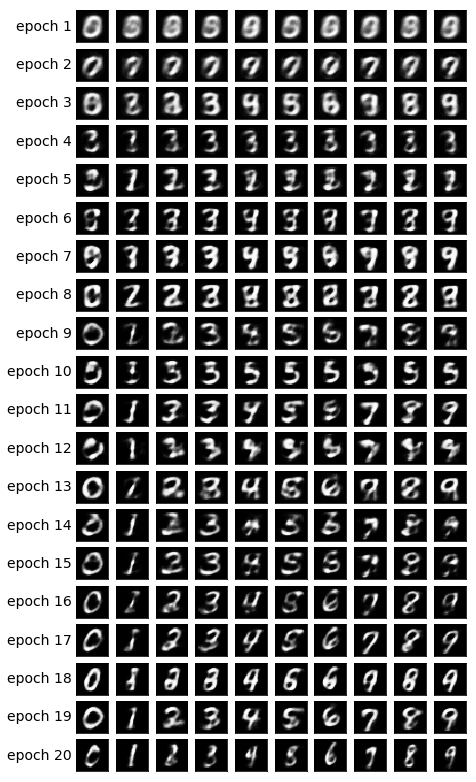

In [9]:
def plot_samples(samples):
    IMAGE_WIDTH = 0.7
    plt.figure(figsize=(IMAGE_WIDTH * num_digits,
                        len(samples) * IMAGE_WIDTH))
    for epoch, images in enumerate(samples):
        for digit, image in enumerate(images):
            plt.subplot(len(samples),
                        num_digits,
                        epoch * num_digits + digit + 1)
            plt.imshow(image.reshape((28, 28)),
                       cmap='Greys_r')
            plt.gca().xaxis.set_visible(False)
            if digit == 0:
                plt.gca().yaxis.set_ticks([])
                plt.ylabel('epoch {}'.format(epoch + 1),
                           verticalalignment='center',
                           horizontalalignment='right',
                           rotation=0,
                           fontsize=14)
            else:
                plt.gca().yaxis.set_visible(False)
                
                
plot_samples(samples)

# Final thoughts
It's nice to see that using a simple feed forward network (no fancy convolutions) we're able to generate nice looking images after merely 20 epochs. The model learned to use the special digit dimensions quite fast - at epoch 9 we already see the sequence of digits we were trying to generate.

Every epoch used different random values for the other dimensions, so we can see how the style differs between epochs, and is similar inside every epoch - at least for some of the epochs. At epoch 18 for instance all the digits are bolder compared to epoch 20.

I invite you to open [this notebook](https://github.com/yoel-zeldes/yoel-zeldes.github.io/blob/source/content/vae2/vae2.ipynb) and play around with the VAE. The hyperparameter values for instance have a great effect over the generated images. Have fun :)